In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

import os
from glob import glob
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from src.utils import tqdm_joblib

In [3]:
meta = pd.read_csv('data/train_meta.csv', index_col='ID')
np.unique(meta.extent, return_counts=True)

(array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 array([21558,   729,   690,   727,   696,   445,   388,   199,   291,
          300,    45]))

In [13]:
subset = meta[np.logical_and(meta['damage'] == 'DR', meta.growth_stage.isin(['F', 'M', 'V']))]
pd.crosstab(subset['season'], subset['extent'])

extent,0,10,20,30,40,50,60,70,80,90,100
season,,,,,,,,,,,
LR2020,0,56,67,51,48,37,38,31,45,18,0
LR2021,6,216,241,293,312,148,113,39,21,16,3
SR2020,0,163,115,84,103,103,109,64,180,224,0
SR2021,0,292,262,295,231,156,128,64,44,42,38


In [67]:
pd.crosstab(meta['growth_stage'], meta['extent'])

extent,0,10,20,30,40,50,60,70,80,90,100
growth_stage,,,,,,,,,,,
F,5314,212,163,153,121,64,39,33,25,30,10
M,3428,438,443,499,514,354,322,146,251,262,7
S,3205,2,5,4,2,1,0,1,1,0,4
V,9611,77,79,71,59,26,27,19,14,8,24


In [69]:
pd.crosstab(meta['damage'], meta['extent'])

extent,0,10,20,30,40,50,60,70,80,90,100
damage,,,,,,,,,,,
DR,6,729,690,727,696,445,388,199,291,300,45
DS,115,0,0,0,0,0,0,0,0,0,0
FD,13,0,0,0,0,0,0,0,0,0,0
G,11623,0,0,0,0,0,0,0,0,0,0
ND,272,0,0,0,0,0,0,0,0,0,0
PS,254,0,0,0,0,0,0,0,0,0,0
WD,9238,0,0,0,0,0,0,0,0,0,0
WN,37,0,0,0,0,0,0,0,0,0,0


In [71]:
pd.crosstab(meta[meta['damage'] == 'DR'].growth_stage, meta.extent)

extent,0,10,20,30,40,50,60,70,80,90,100
growth_stage,,,,,,,,,,,
F,2,212,163,153,121,64,39,33,25,30,10
M,2,438,443,499,514,354,322,146,251,262,7
S,0,2,5,4,2,1,0,1,1,0,4
V,2,77,79,71,59,26,27,19,14,8,24


In [63]:
train_df = pd.read_csv('data/Train.csv')
test_df = pd.read_csv('data/Test.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/Train.csv'

In [ ]:
train_df.head()

,ID,filename,growth_stage,damage,extent,season
0,ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020
1,ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021
2,ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020
3,ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020
4,ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0,SR2021


In [ ]:
test_df.head()

,ID,filename,growth_stage,damage,season
0,ID_ROOWKB90UZ,L122F00315C01S02151Rp04021.jpg,V,WD,SR2020
1,ID_PTEDRY0CYM,L1089F03254C01S08845Rp25119.jpg,F,WD,LR2021
2,ID_5WJXDV96R4,L365F01913C39S12578Rp42918.jpg,V,WD,SR2021
3,ID_DM4AQLXXYG,223_repeat_2_2230_3599_2343.JPG,F,G,LR2020
4,ID_V6YTIT7I2S,L354F00276C01S08045Rp23693.jpg,F,G,LR2021


In [ ]:
train_df.shape

(26068, 6)

In [ ]:
pd.unique(train_df.ID).shape

(26068,)

In [ ]:
pd.unique(train_df.filename).shape

(26068,)

In [ ]:
image = np.array(Image.open(os.path.join('data/train', train_df.filename.iloc[0])).convert("RGB"))

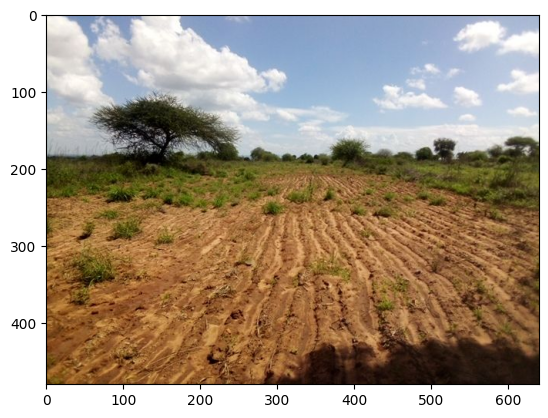

In [ ]:
plt.imshow(image)

In [ ]:
files = list(filter(lambda x: '1_repeat_2_2855' in x, train_df.filename.values))

In [ ]:
train_df.loc[train_df.filename.isin(files)] 

,ID,filename,growth_stage,damage,extent,season
1821,ID_HHCX0F924Z,1_repeat_2_2855_6007_4368.JPG,F,G,0,LR2020
4761,ID_3UH3ZNIPSE,1_repeat_2_2855_6300_4666.JPG,M,ND,0,LR2020
4869,ID_5BKC8DQ707,1_repeat_2_2855_5694_4070.JPG,M,G,0,LR2020


In [ ]:
np.unique(train_df.extent, return_counts=True)

(array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 array([21558,   729,   690,   727,   696,   445,   388,   199,   291,
          300,    45]))

In [ ]:
def readImage(root, filename):
    return np.array(Image.open(os.path.join(root, filename)).convert("RGB"))

In [ ]:
sizes = map(lambda filename : readImage('data/train', filename).shape[:2], train_df.filename.values[:1000])

In [ ]:
def process(root, filename):
    return filename, readImage(root, filename).shape[:2]

with tqdm_joblib(tqdm(desc="Processing", total=train_df.shape[0])) as progress_bar:
    pairs = Parallel(n_jobs=-1)(delayed(process)('data/train', filename) for filename in train_df.filename.values)

Processing:   0%|          | 0/26068 [00:00<?, ?it/s]

In [ ]:
temp_df = pd.DataFrame(data=pairs, columns=['filename', 'shape']).set_index('filename')
train_df = train_df.join(temp_df, on='filename')

In [ ]:
with tqdm_joblib(tqdm(desc="Processing", total=test_df.shape[0])) as progress_bar:
    pairs = Parallel(n_jobs=-1)(delayed(process)('data/test', filename) for filename in test_df.filename.values)

Processing:   0%|          | 0/8663 [00:00<?, ?it/s]

In [ ]:
temp_df = pd.DataFrame(data=pairs, columns=['filename', 'shape']).set_index('filename')
test_df = test_df.join(temp_df, on='filename')

In [ ]:
train_df.to_csv('data/Train_new.csv')
test_df.to_csv('data/Test_new.csv')

In [ ]:
df = train_df.groupby(by='shape').first()
df['shape'] = df.index
df.set_index(pd.Index(range(df.shape[0])), inplace=True)

fig, axes = plt.subplots(7, 6, figsize=(60,70))

for i in range(df.shape[0]):
    axes[i % axes.shape[0], i % axes.shape[1]].imshow(readImage('data/train', df.iloc[i]['filename']))
    axes[i % axes.shape[0], i % axes.shape[1]].set_title(df.iloc[i]['shape'])

In [ ]:
df = test_df.groupby(by='shape').first()
df['shape'] = df.index
df.set_index(pd.Index(range(df.shape[0])), inplace=True)

fig, axes = plt.subplots(7, 6, figsize=(60,70))

for i in range(df.shape[0]):
    axes[i % axes.shape[0], i % axes.shape[1]].imshow(readImage('data/test', df.iloc[i]['filename']))
    axes[i % axes.shape[0], i % axes.shape[1]].set_title(df.iloc[i]['shape'])

In [ ]:
df = train_df.groupby(by='shape').first()
df['shape'] = df.index
df.set_index(pd.Index(range(df.shape[0])), inplace=True)

fig, axes = plt.subplots(7, 6, figsize=(60,70))

for i in range(df.shape[0]):
    image = readImage('data/train', df.iloc[i]['filename'])
    image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_CUBIC)
    axes[i % axes.shape[0], i % axes.shape[1]].imshow(image)
    axes[i % axes.shape[0], i % axes.shape[1]].set_title(df.iloc[i]['shape'])

# Splits

## Default

In [ ]:
df = pd.read_csv('data/Train_new.csv')
train, valid = train_test_split(df, test_size=0.25, random_state=2023, shuffle=True, stratify=df.extent)

In [ ]:
train.to_csv('data/splits/train.csv')
valid.to_csv('data/splits/valid.csv')

## Binary, subset class 0, stratify over season and extent

In [56]:
meta = pd.read_csv('data/train_meta.csv', index_col='ID')
meta.extent = np.int_(meta.extent > 0)

meta_0 = meta[meta.extent == 0].index
meta_1 = meta[meta.extent == 1].index

meta_0_ids = np.empty(0)

for season in pd.unique(meta.season):
    count = (meta.loc[meta_1].season == season).sum()
    ids = meta_0[meta.loc[meta_0].season == season].values
    indices = np.random.randint(0, ids.shape[0], count)
    meta_0_ids = np.concatenate([meta_0_ids, ids[indices]])

subset = meta.loc[np.concatenate([meta_1, meta_0_ids])]
df = pd.DataFrame({'ID' : subset.index})
train, valid = train_test_split(df, test_size=0.25, random_state=2023, shuffle=True, stratify=subset.extent.astype(str) + subset.season)

train.set_index('ID', inplace=True)
valid.set_index('ID', inplace=True)

In [58]:
np.unique(meta.loc[train.index].season, return_counts=True)

(array(['LR2020', 'LR2021', 'SR2020', 'SR2021'], dtype=object),
 array([ 586, 2110, 1720, 2349]))

In [59]:
np.unique(meta.loc[valid.index].season, return_counts=True)

(array(['LR2020', 'LR2021', 'SR2020', 'SR2021'], dtype=object),
 array([196, 704, 572, 783]))

In [60]:
train.to_csv('data/splits/train_reduced/train.csv', index='ID')
valid.to_csv('data/splits/train_reduced/valid.csv', index='ID')

## Only pos classes

In [2]:
meta = pd.read_csv('data/train_meta.csv', index_col='ID')
meta.head()

,filename,growth_stage,damage,extent,season,shape
ID,,,,,,
ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020,"(480, 640)"
ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021,"(240, 320)"
ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020,"(480, 640)"
ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020,"(480, 640)"
ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0,SR2021,"(240, 320)"


In [3]:
subset = meta[meta.extent > 0]
df = pd.DataFrame({'ID' : subset.index})
train, valid = train_test_split(df, test_size=0.25, random_state=2023, shuffle=True, stratify=subset.extent.astype(str) + subset.season)

train.set_index('ID', inplace=True)
valid.set_index('ID', inplace=True)

In [4]:
np.unique(meta.loc[train.index].season, return_counts=True)

(array(['LR2020', 'LR2021', 'SR2020', 'SR2021'], dtype=object),
 array([ 294, 1055,  859, 1174]))

In [5]:
np.unique(meta.loc[valid.index].season, return_counts=True)

(array(['LR2020', 'LR2021', 'SR2020', 'SR2021'], dtype=object),
 array([ 97, 352, 287, 392]))

In [7]:
np.unique(meta.loc[train.index].extent, return_counts=True)

(array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 array([547, 516, 545, 522, 334, 292, 149, 219, 225,  33]))

In [6]:
np.unique(meta.loc[valid.index].extent, return_counts=True)

(array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 array([182, 174, 182, 174, 111,  96,  50,  72,  75,  12]))

In [8]:
train.to_csv('data/splits/train_do.csv', index='ID')
valid.to_csv('data/splits/valid_do.csv', index='ID')

## Only pos classes, sampled

In [10]:
train = pd.read_csv('data/splits/train_do.csv', index_col='ID')
np.unique(meta.loc[train.index].extent, return_counts=True)

(array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 array([547, 516, 545, 522, 334, 292, 149, 219, 225,  33]))

In [11]:
meta_subset = meta.loc[train.index]
values, counts = np.unique(meta_subset.extent, return_counts=True)
max_count = counts.max()

for i, value in enumerate(values):
    add_count = max_count - counts[i] 
    subset = meta_subset[meta_subset.extent == value].index
    new_objects = subset[np.random.randint(0, subset.shape[0], add_count)]
    train = pd.concat([train, pd.DataFrame(data={'ID': new_objects.values}).set_index('ID')])

train.to_csv('data/splits/train_do_sampled.csv', index='ID')
np.unique(meta.loc[train.index].extent, return_counts=True)

(array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 array([547, 547, 547, 547, 547, 547, 547, 547, 547, 547]))

## By season and year

In [ ]:
df = pd.read_csv('data/train_meta.csv', index_col='ID')
df.head()

,filename,growth_stage,damage,extent,season,shape
ID,,,,,,
ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020,"(480, 640)"
ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021,"(240, 320)"
ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020,"(480, 640)"
ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020,"(480, 640)"
ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0,SR2021,"(240, 320)"


In [ ]:
for season in pd.unique(df.season):
    train, valid = train_test_split(pd.DataFrame({'ID' : df[df.season == season].index}), test_size=0.25, random_state=2023, shuffle=True, stratify=df[df.season == season].extent)
    train.set_index('ID', inplace=True)
    valid.set_index('ID', inplace=True)
    train.to_csv(f'data/splits/by_season_and_year/train_{season}.csv', index='ID')
    valid.to_csv(f'data/splits/by_season_and_year/valid_{season}.csv', index='ID')

## By growth stage

In [ ]:
df = pd.read_csv('data/train_meta.csv', index_col='ID')
df.head()

,filename,growth_stage,damage,extent,season,shape
ID,,,,,,
ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020,"(480, 640)"
ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021,"(240, 320)"
ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020,"(480, 640)"
ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020,"(480, 640)"
ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0,SR2021,"(240, 320)"


In [ ]:
for growth_stage in pd.unique(df.growth_stage):
    train, valid = train_test_split(pd.DataFrame({'ID' : df[df.growth_stage == growth_stage].index}), test_size=0.25, random_state=2023, shuffle=True, stratify=df[df.growth_stage == growth_stage].extent)
    train.set_index('ID', inplace=True)
    valid.set_index('ID', inplace=True)
    train.to_csv(f'data/splits/by_gs/train_{growth_stage}.csv', index='ID')
    valid.to_csv(f'data/splits/by_gs/valid_{growth_stage}.csv', index='ID')

## Special

In [81]:
df = pd.read_csv('data/train_meta.csv', index_col='ID')
df.head()

,filename,growth_stage,damage,extent,season,shape
ID,,,,,,
ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020,"(480, 640)"
ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021,"(240, 320)"
ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020,"(480, 640)"
ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020,"(480, 640)"
ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0,SR2021,"(240, 320)"


Only objects with damage type "DR", growth_stage "S" is excluded, objects with extent 0 are excluded, extent shifted 

In [82]:
subset = df[np.logical_and(np.logical_and(df.damage == 'DR', df.growth_stage.isin(['F', 'M', 'V'])), df.extent != 0)]

In [83]:
train, valid = train_test_split(pd.DataFrame({'ID' : subset.index}), test_size=0.25, random_state=2023, shuffle=True, stratify=subset.extent)
train.set_index('ID', inplace=True)
valid.set_index('ID', inplace=True)
train.to_csv(f'data/splits/special/train.csv', index='ID')
valid.to_csv(f'data/splits/special/valid.csv', index='ID')

In [3]:
train = pd.read_csv('data/splits/special/train.csv', index_col='ID')
meta = pd.read_csv('data/train_meta.csv', index_col='ID')

In [10]:
meta_subset = meta[meta.index.isin(train.index)]
values, counts = np.unique(meta_subset.extent, return_counts=True)
max_count = counts.max()

In [21]:
for i, value in enumerate(values):
    add_count = max_count - counts[i] 
    subset = meta_subset[meta_subset.extent == value].index
    new_objects = subset[np.random.randint(0, subset.shape[0], add_count)]
    train = pd.concat([train, pd.DataFrame(data={'ID': new_objects.values}).set_index('ID')])
 

In [26]:
train.to_csv('data/splits/special/train_balanced.csv', index='ID')

## G

In [62]:
meta = pd.read_csv('data/train_meta.csv', index_col='ID')
meta = meta[np.logical_and(meta['damage'] == 'DR', meta.growth_stage.isin(['F', 'M', 'V']))]

In [63]:
pd.crosstab(meta['season'], meta['extent'])

extent,0,10,20,30,40,50,60,70,80,90,100
season,,,,,,,,,,,
LR2020,0,56,67,51,48,37,38,31,45,18,0
LR2021,6,216,241,293,312,148,113,39,21,16,3
SR2020,0,163,115,84,103,103,109,64,180,224,0
SR2021,0,292,262,295,231,156,128,64,44,42,38


### LR2020

In [64]:
subset = meta[meta.season == 'LR2020']
subset.head()

,filename,growth_stage,damage,extent,season,shape
ID,,,,,,
ID_XDXII5MWL0,201_repeat_2_1382_6311_4680.JPG,M,DR,10,LR2020,"(480, 640)"
ID_WAMKLEK3PM,187_repeat_2_2047_6262_4629.JPG,M,DR,50,LR2020,"(480, 640)"
ID_SSN6EQ9O96,158_repeat_2_1490_4721_3091.JPG,M,DR,30,LR2020,"(480, 640)"
ID_Z6RRSQWYY3,201_repeat_2_1382_6411_4777.JPG,M,DR,80,LR2020,"(480, 640)"
ID_YE1HA1VTM0,158_repeat_2_1490_5208_3563.JPG,M,DR,50,LR2020,"(480, 640)"


In [65]:
df = pd.DataFrame({'ID' : subset.index})
train, valid = train_test_split(df, test_size=0.25, random_state=2023, shuffle=True, stratify=subset.extent)

train.set_index('ID', inplace=True)
valid.set_index('ID', inplace=True)

train.to_csv('data/splits/new/lr2020_train.csv', index='ID')
valid.to_csv('data/splits/new/lr2020_valid.csv', index='ID')

In [66]:
meta_subset = meta[meta.index.isin(train.index)]
values, counts = np.unique(meta_subset.extent, return_counts=True)
max_count = counts.max()

for i, value in enumerate(values):
    add_count = max_count - counts[i] 
    subset = meta_subset[meta_subset.extent == value].index
    new_objects = subset[np.random.randint(0, subset.shape[0], add_count)]
    train = pd.concat([train, pd.DataFrame(data={'ID': new_objects.values}).set_index('ID')])

train.to_csv('data/splits/new/lr2020_train_balanced.csv', index='ID')

### LR2021

In [67]:
subset = meta[meta.season == 'LR2021']
subset = meta[np.logical_not(meta.extent.isin([0,100]))]
subset.head()

,filename,growth_stage,damage,extent,season,shape
ID,,,,,,
ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020,"(480, 640)"
ID_BVNP8C4M1N,L331F04678C01S11060Rp30683.jpg,M,DR,40,LR2021,"(480, 640)"
ID_MFL3FVUKDA,L133F00737C01S06945Rp25674.jpg,F,DR,60,LR2021,"(480, 640)"
ID_NFYJ8T2V5W,L432F01720C01S04931Rp13768.jpg,M,DR,20,SR2020,"(480, 640)"
ID_C74KHW4OK5,L133F03014C01S00293Rp10017.jpg,M,DR,50,SR2020,"(480, 640)"


In [68]:
df = pd.DataFrame({'ID' : subset.index})
train, valid = train_test_split(df, test_size=0.25, random_state=2023, shuffle=True, stratify=subset.extent)

train.set_index('ID', inplace=True)
valid.set_index('ID', inplace=True)

train.to_csv('data/splits/new/lr2021_train.csv', index='ID')
valid.to_csv('data/splits/new/lr2021_valid.csv', index='ID')

In [69]:
meta_subset = meta[meta.index.isin(train.index)]
values, counts = np.unique(meta_subset.extent, return_counts=True)
max_count = counts.max()

for i, value in enumerate(values):
    add_count = max_count - counts[i] 
    subset = meta_subset[meta_subset.extent == value].index
    new_objects = subset[np.random.randint(0, subset.shape[0], add_count)]
    train = pd.concat([train, pd.DataFrame(data={'ID': new_objects.values}).set_index('ID')])

train.to_csv('data/splits/new/lr2021_train_balanced.csv', index='ID')

### SR2020

In [70]:
subset = meta[meta.season == 'SR2020']
subset.head()

,filename,growth_stage,damage,extent,season,shape
ID,,,,,,
ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020,"(480, 640)"
ID_NFYJ8T2V5W,L432F01720C01S04931Rp13768.jpg,M,DR,20,SR2020,"(480, 640)"
ID_C74KHW4OK5,L133F03014C01S00293Rp10017.jpg,M,DR,50,SR2020,"(480, 640)"
ID_BDV1VQRJAS,L398F00102C01S01131Rp13276.jpg,M,DR,50,SR2020,"(480, 640)"
ID_L3YYRSTAP8,L134F00762C01S05370Rp14099.jpg,M,DR,70,SR2020,"(480, 640)"


In [71]:
df = pd.DataFrame({'ID' : subset.index})
train, valid = train_test_split(df, test_size=0.25, random_state=2023, shuffle=True, stratify=subset.extent)

train.set_index('ID', inplace=True)
valid.set_index('ID', inplace=True)

train.to_csv('data/splits/new/sr2020_train.csv', index='ID')
valid.to_csv('data/splits/new/sr2020_valid.csv', index='ID')

In [72]:
meta_subset = meta[meta.index.isin(train.index)]
values, counts = np.unique(meta_subset.extent, return_counts=True)
max_count = counts.max()

for i, value in enumerate(values):
    add_count = max_count - counts[i] 
    subset = meta_subset[meta_subset.extent == value].index
    new_objects = subset[np.random.randint(0, subset.shape[0], add_count)]
    train = pd.concat([train, pd.DataFrame(data={'ID': new_objects.values}).set_index('ID')])

train.to_csv('data/splits/new/sr2020_train_balanced.csv', index='ID')

### SR2021

In [73]:
subset = meta[meta.season == 'SR2021']
subset.head()

,filename,growth_stage,damage,extent,season,shape
ID,,,,,,
ID_53R92CXW1E,L1094F03163C39S11589Rp41682.jpg,M,DR,40,SR2021,"(240, 320)"
ID_C0Q01LUY08,L1136F02414C39S11646Rp36950.jpg,M,DR,30,SR2021,"(2448, 3264)"
ID_RGAOGKO8US,L1153F04303C39S11884Rp40163.jpg,F,DR,50,SR2021,"(240, 320)"
ID_P32U5VMIB6,L1094F01748C39S11585Rp41669.jpg,M,DR,30,SR2021,"(240, 320)"
ID_HP0YVFHP6M,L144F01437C39S12514Rp48970.jpg,M,DR,50,SR2021,"(240, 320)"


In [74]:
df = pd.DataFrame({'ID' : subset.index})
train, valid = train_test_split(df, test_size=0.25, random_state=2023, shuffle=True, stratify=subset.extent)

train.set_index('ID', inplace=True)
valid.set_index('ID', inplace=True)

train.to_csv('data/splits/new/sr2021_train.csv', index='ID')
valid.to_csv('data/splits/new/sr2021_valid.csv', index='ID')

In [75]:
meta_subset = meta[meta.index.isin(train.index)]
values, counts = np.unique(meta_subset.extent, return_counts=True)
max_count = counts.max()

for i, value in enumerate(values):
    add_count = max_count - counts[i] 
    subset = meta_subset[meta_subset.extent == value].index
    new_objects = subset[np.random.randint(0, subset.shape[0], add_count)]
    train = pd.concat([train, pd.DataFrame(data={'ID': new_objects.values}).set_index('ID')])

train.to_csv('data/splits/new/sr2021_train_balanced.csv', index='ID')

# Loss weights

In [2]:
from sklearn.utils import class_weight

## Balanced

### Default

In [3]:
df = pd.read_csv('data/splits/train.csv', index_col='ID')
meta = pd.read_csv('data/train_meta.csv', index_col='ID')
meta.extent = np.int_(meta.extent > 0)

y = meta[meta.index.isin(df.index)].extent
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

In [4]:
weights

array([0.60458284, 2.89044944])

### By season and year

In [ ]:
meta = pd.read_csv('data/train_meta.csv', index_col='ID')
meta.head()

,filename,growth_stage,damage,extent,season,shape
ID,,,,,,
ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020,"(480, 640)"
ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021,"(240, 320)"
ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020,"(480, 640)"
ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020,"(480, 640)"
ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0,SR2021,"(240, 320)"


In [62]:
n_classes = 11

for season in pd.unique(meta.season):
    df = pd.read_csv(f'data/splits/by_season_and_year/train_{season}.csv', index_col='ID')
    y = meta[meta.index.isin(df.index)].extent
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    if weights.shape[0] == 10: weights = np.hstack([weights, 100])
    np.save(f'data/class_weights/by_season_and_year/weights_{season}.npy', weights)
    print(season, weights.shape, np.unique(y))

SR2020 (11,) [ 0 10 20 30 40 50 60 70 80 90]
SR2021 (11,) [  0  10  20  30  40  50  60  70  80  90 100]
LR2020 (11,) [ 0 10 20 30 40 50 60 70 80 90]
LR2021 (11,) [  0  10  20  30  40  50  60  70  80  90 100]


### Special

In [78]:
meta = pd.read_csv('data/train_meta.csv', index_col='ID')
meta.head()

,filename,growth_stage,damage,extent,season,shape
ID,,,,,,
ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020,"(480, 640)"
ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021,"(240, 320)"
ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020,"(480, 640)"
ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020,"(480, 640)"
ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0,SR2021,"(240, 320)"


In [84]:
subset = df[np.logical_and(np.logical_and(df.damage == 'DR', df.growth_stage.isin(['F', 'M', 'V'])), df.extent != 0)]

In [85]:
df = pd.read_csv(f'data/splits/special/train.csv', index_col='ID')
y = meta[meta.index.isin(df.index)].extent
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

np.save(f'data/class_weights/special/weights.npy', weights)
print(weights.shape, np.unique(y))

(10,) [ 10  20  30  40  50  60  70  80  90 100]


In [ ]:
df = train_df.groupby(by='shape').first()
df['shape'] = df.index
df.set_index(pd.Index(range(41)))

,ID,filename,growth_stage,damage,extent,season,shape
0,ID_HD5KQU4HDV,L144F02115C39S12863Dp36557.jpg,S,G,0,SR2021,"(102, 204)"
1,ID_DH2PC46M5Q,L1095F03416C39S13817Dp43707.jpg,M,G,0,SR2021,"(120, 120)"
2,ID_P6BBV72N7U,L1153F04300C39S11886Dp37165.jpg,F,DR,20,SR2021,"(120, 160)"
3,ID_SSS01WDZLR,L1153F04299C39S11874Dp32596.jpg,V,PS,0,SR2021,"(121, 162)"
4,ID_XDLD8OZ11F,L332F03215C39S12314Dp37307.jpg,V,PS,0,SR2021,"(144, 192)"
5,ID_RJQQJQOE74,L113F01130C39S12989Ip.jpg,V,G,0,SR2021,"(144, 256)"
6,ID_BYGE45N6FI,L1083F00926C39S12675Dp34698.jpg,V,G,0,SR2021,"(153, 204)"
7,ID_0KGLB2R5E6,L1153F04302C39S11876Dp35837.jpg,V,DR,20,SR2021,"(160, 120)"
8,ID_ZDM5EG78PF,L243F04639C39S12665Dp33757.jpg,V,PS,0,SR2021,"(161, 121)"
9,ID_403EZ3F0QP,L1150F02014C39S14860Dp38300.jpg,F,WD,0,SR2021,"(162, 122)"


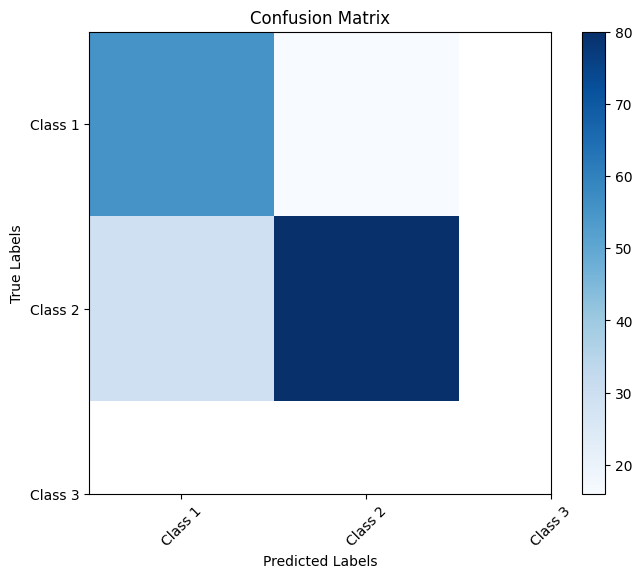

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def confusion_matrix_from_tp_fp_tn_fn(tp, fp, tn, fn):
    conf_matrix = np.array([[tp, fp], [fn, tn]])
    return conf_matrix

# Replace these values with TP, FP, TN, FN for each class
# Sample values are provided for demonstration purposes.
# Make sure the values are consistent with your data.
tp_class1, fp_class1, tn_class1, fn_class1 = 15, 5, 20, 10
tp_class2, fp_class2, tn_class2, fn_class2 = 30, 8, 25, 12
tp_class3, fp_class3, tn_class3, fn_class3 = 10, 3, 35, 7

# Calculate the number of classes
num_classes = 3

# Calculate the confusion matrix for each class
conf_matrix_class1 = confusion_matrix_from_tp_fp_tn_fn(tp_class1, fp_class1, tn_class1, fn_class1)
conf_matrix_class2 = confusion_matrix_from_tp_fp_tn_fn(tp_class2, fp_class2, tn_class2, fn_class2)
conf_matrix_class3 = confusion_matrix_from_tp_fp_tn_fn(tp_class3, fp_class3, tn_class3, fn_class3)

# Sum the confusion matrices for all classes to get the overall confusion matrix
conf_matrix = np.sum([conf_matrix_class1, conf_matrix_class2, conf_matrix_class3], axis=0)

# Define class labels (modify according to your data)
class_labels = ['Class 1', 'Class 2', 'Class 3']

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
transforms = A.Compose([
    A.Normalize(mean=(0,0,0), std=(1,1,1), always_apply=True),
    ToTensorV2()
])

In [ ]:
image = np.array(Image.open(os.path.join('data/train', train_df.filename.iloc[0])).convert("RGB"))

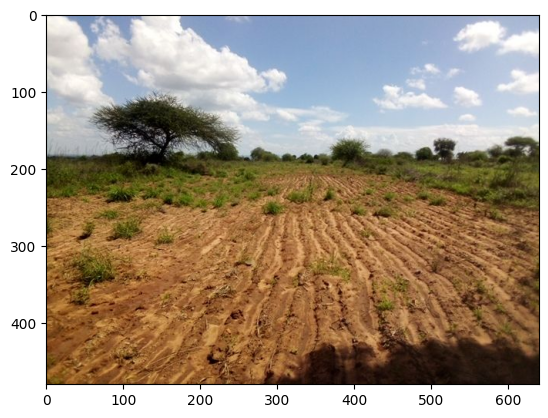

In [ ]:
plt.imshow(image)

In [ ]:
image.shape

(480, 640, 3)

In [ ]:
image.min(), image.max()

(0, 255)

In [ ]:
transformed = transforms(image=image)['image']

In [ ]:
transformed.shape

torch.Size([3, 480, 640])

In [ ]:
transformed.min(), transformed.max()

(tensor(0.), tensor(1.))

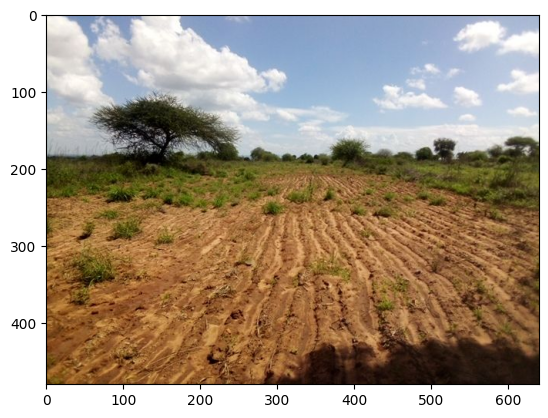

In [ ]:
plt.imshow(transformed.permute((1,2,0)))

In [ ]:
from torchvision.models import efficientnet_b0, resnet18
import timm

In [ ]:
import torch.nn as nn

In [ ]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [ ]:
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=10)

In [ ]:
import torch
x = torch.ones((2,3,512,512))
model(x).shape

torch.Size([2, 10])

In [ ]:
class model(nn.Module):
    def __init__(self, base_model):
        super(model, self).__init__()
        
        self.features = base_model.features
        self.pooling = nn.AdaptiveMaxPool2d(output_size=1)
        self.classification = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(in_features=2560, out_features=11, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = self.classification(x)

        return x

In [ ]:
resnet18("IMAGENET1K_V1")

/trinity/home/georgy.popandopulo/.conda/envs/cgiar/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /trinity/home/georgy.popandopulo/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 80.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
m = model(efficientnet_b0("IMAGENET1K_V1"))

/trinity/home/georgy.popandopulo/.conda/envs/cgiar/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
efficientnet_b0(weights="IMAGENET1K_V1").features

AttributeError: 'Sequential' object has no attribute 'Conv2dNormActivation'

In [ ]:
list(list(list(efficientnet_b0(weights="IMAGENET1K_V1").features.children())[-1].children())[1].parameters())[0].shape

torch.Size([1280])

In [ ]:
x = torch.ones((2,3,221,221))
m(x).shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1280 and 2560x11)

In [ ]:
from src.dataset import DamageDataset
from torch.utils.data import DataLoader

In [ ]:
root = 'data/train'
split = 'data/splits/train.csv'
metadata = 'data/train_meta.csv'

dataset = DamageDataset(root, split, metadata)
loader = DataLoader(dataset, batch_size=8)

In [ ]:
for idx, _, _ in loader:
    print(idx)
    break

TypeError: Cannot index by location index with a non-integer key

In [ ]:
import torch
a = np.array(['ydy', 'dhd'])

In [ ]:
torch.from_numpy(a)

TypeError: can't convert np.ndarray of type numpy.str_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.